# Работа с массивами данных при помощи Pandas

Нам понадобится `pip install pandas scipy tables vitables`.

Из дополнительных материалов рекомендуется этот текст: https://khashtamov.com/ru/pandas-introduction/

Мы немножко попробуем, как [Карлсон](https://web.archive.org/web/20190305185555if_/https://cs10.pikabu.ru/post_img/2018/07/10/4/1531199339121474094.jpg).

Будем сразу играть за две стороны. Точнее за три. За хорошего математика, за плохого математика и за себя.

## Хороший математик

Откуда-то взял числа, нормально распределённые. Наверное он [кидал монетку 50 раз по 25 бросков](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%82%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0) и каждый раз записывал среднее количество орлов.

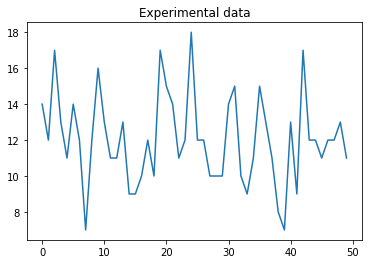

In [1]:
%matplotlib inline  

import pandas
import random

import matplotlib
import numpy
import matplotlib.pyplot as plt

ntries = 50
throws = 25

rgen = random.Random()

experiments = []
for e in range(ntries):
    v = 0
    for r in range(throws):
        v += rgen.randint(0, 1)
    experiments.append(v)

plt.plot(list(range(ntries)), experiments)
plt.title('Experimental data')
plt.show()

Эти данные нам прислал хороший математик. Для этого он воспользовался форматом CSV.

In [2]:
import pandas

df = pandas.DataFrame(data={
    'experiments': experiments
})

df.to_csv("experiments.csv")

## Плохой математик

Где-то получил эти данные, запортил их, и, чтобы мы его не очень ассоциировали с хорошим, отправил данные в формате HDF5

In [3]:
df.loc[df.experiments % 4 == 0, 'experiments'] = 0
df.loc[df.experiments % 4 == 1, 'experiments'] = throws
df.to_hdf("experiments.h5", "experiments")

... посмотрел при помощи ViTables, мерзко захихикал и тоже нам отправил.

## Мы

Получили два набора данных, подозреваем, что что-то не так, но не знаем, какой из них хороший, а какой плохой.

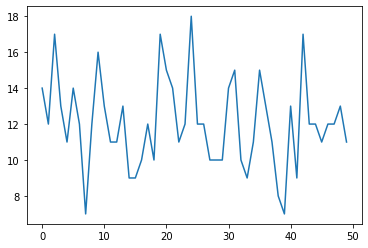

In [4]:
try:
    del df
except:
    pass

df1 = pandas.read_csv("experiments.csv")
df2 = pandas.read_hdf("experiments.h5")

df1['experiments'].plot()

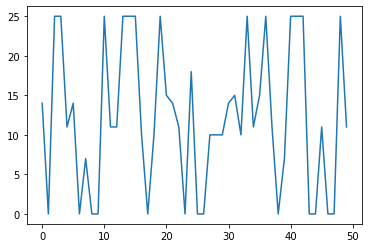

In [5]:
df2['experiments'].plot()

Что-то и правда не сходится. Посмотрим на *плотность распределения*...

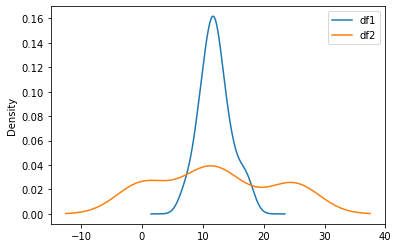

In [6]:
df12 = pandas.DataFrame(data={
    'df1': df1['experiments'],
    'df2': df2['experiments'],
})

df12.plot.kde()

Что-то с `df2` с виду не похож на *нормальное распределение*, хотя должен бы...

А мы можем это оценить численно, или нет? Можем. При помощи критерия Колмогорова-Смирнова.

Гипотеза: данное распределение близко к нормальному.

В результате проверки вычисляются два числа — *К-С-статистика* и *P-значение*. Если первое мало или второе велико, мы гипотезу отвергнуть не можем. В противном случае, гипотеза может считаться ошибочной.

In [7]:
from scipy import stats

d1 = df12['df1']
d2 = df12['df2']

# If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
print(stats.kstest(d1, 'norm', (d1.mean(), d1.std())))
print(stats.kstest(d2, 'norm', (d2.mean(), d2.std())))

KstestResult(statistic=0.14634490297466357, pvalue=0.21284145254012013)
KstestResult(statistic=0.17718377007762243, pvalue=0.07627919581191156)


Видим, что для первого распределения *К-С-статистика* ниже, чем для второго, но не намного. Зато *P-значение* для первого заметно выше. Т.е. первое «более нормальное».